# Set up enviroment

In [124]:
import numpy as np
import pandas as pd
import os
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import joblib
import datetime

In [125]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [139]:
tokens = ["btc", "eth", "xrp"]
train_test_split = ["721", "622", "811"]

data_source = '/content/drive/My Drive/Report_DBA/final_report/'
processed_output_dir = os.path.join(data_source,  "processing/")

targets = ["Close"]

data_set = {1: "train", 2: "test", 3: "validation"}


model_name = "linear_regression"

T = 60 # ----> lookback
TF = 1 # ----> predict
NFeature = 1 # ----> feautures

# working on
token_id = 2
# n_split = 0 # 721
n_split = 1 # 622
# n_split = 2 # 811


In [140]:
%cd $data_source
# !ls

/content/drive/My Drive/Report_DBA/final_report


In [141]:
# load scaler
scaler = joblib.load(os.path.join(f"{processed_output_dir}/{tokens[token_id]}/{train_test_split[n_split]}", f"{targets[0]}_train_scalerMinMaxNorm.save"))

# Build Model

In [142]:
def buildModel():
  model = LinearRegression()
  return model

# Start

In [143]:
df = pd.read_csv(f"data/{tokens[token_id]}.csv", index_col="Date")
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-12-01,0.250352,0.258828,0.239438,0.255699,0.255699,182992000
2017-12-02,0.255656,0.259218,0.250756,0.255492,0.255492,118250000
2017-12-03,0.255530,0.263072,0.247391,0.252558,0.252558,134710000
2017-12-04,0.252919,0.255362,0.247160,0.253571,0.253571,104650000
2017-12-05,0.253598,0.253988,0.245234,0.246101,0.246101,174591008


In [144]:
n_observations = df.shape[0]
df.reset_index(inplace = True)

train_size = 0.7
test_size = 0.2

train = df.iloc[:int(n_observations*train_size)]
test = df.iloc[int(n_observations*train_size) : int(n_observations*train_size) + int(n_observations * test_size)]
val = df.iloc[-int(n_observations * (1 - train_size - test_size)):]

In [145]:
Xtrain, Ytrain = np.array(train.index).reshape(-1,1), train.Close
Xtest, Ytest = np.array(test.index).reshape(-1,1), test.Close
Xval, Yval = np.array(val.index).reshape(-1,1), val.Close

In [146]:
model = buildModel()
model.fit(Xtrain, Ytrain)

model_location = f"Model/{tokens[token_id]}"

# create folder if not exits
os.makedirs(model_location, exist_ok=True)

# save
joblib.dump(model, f"{model_location}/{model_name}_{train_test_split[n_split]}.pkl")

['Model/xrp/linear_regression_622.pkl']

# Test and Visualization

In [147]:
def evaluate(df, title, actual, predict):
  rmse = np.sqrt(mean_squared_error(actual, predict))
  mae = mean_absolute_error(actual, predict)
  mape = mean_absolute_percentage_error(actual, predict)

  df[f"rmse_{title}"].append(rmse)
  df[f"mae_{title}"].append(mae)
  df[f"mape_{title}"].append(mape)
  return df


In [148]:
# load model to predict
model = joblib.load(f"Model/{tokens[token_id]}/{model_name}_{train_test_split[n_split]}.pkl")
model

LinearRegression()

## Predict next 30 days

In [149]:
metrics_df = {
    "rmse_train": [],
    "mae_train": [],
    "mape_train": [],
    "rmse_test": [],
    "mae_test": [],
    "mape_test": [],
    "rmse_val": [],
    "mae_val": [],
    "mape_val": [],
}
# Dự đoán trên tập huấn luyện
y_pred_train = model.predict(Xtrain)
y_pred_test = model.predict(Xtest)
y_pred_val = model.predict(Xval)

metrics_df = evaluate(metrics_df, "train", Ytrain, y_pred_train)
metrics_df = evaluate(metrics_df, "test", Ytest, y_pred_test)
metrics_df = evaluate(metrics_df, "val", Yval, y_pred_val)

metrics_df = pd.DataFrame(metrics_df)

metrics_folder = f"metrics/{tokens[token_id]}"
os.makedirs(metrics_folder, exist_ok=True)
metrics_df.to_excel(f"{metrics_folder}/{model_name}_{train_test_split[n_split]}.xlsx")
metrics_df


,rmse_train,mae_train,mape_train,rmse_test,mae_test,mape_test,rmse_val,mae_val,mape_val
0,0.388391,0.272291,0.661798,0.307242,0.240074,0.337478,0.078789,0.069196,0.178784


Predicted closing prices for the next 30 days:
[0.47041286 0.47038899 0.47036511 0.47034124 0.47031737 0.47029349
 0.47026962 0.47024574 0.47022187 0.47019799 0.47017412 0.47015025
 0.47012637 0.4701025  0.47007862 0.47005475 0.47003087 0.470007
 0.46998313 0.46995925 0.46993538 0.4699115  0.46988763 0.46986375
 0.46983988 0.46981601 0.46979213 0.46976826 0.46974438 0.46972051]


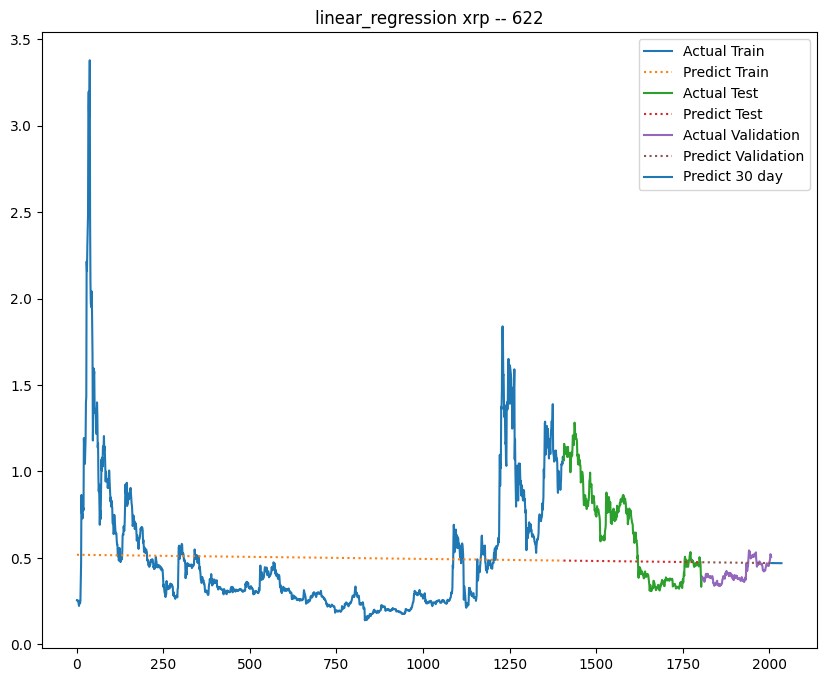

In [150]:

# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(x_next_30_days)

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

pred_list = np.array(y_next_30_days)

color_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

plt.figure(figsize=(10, 8))

# train
train_range = range(0, len(Ytrain.squeeze()))
plt.plot([*train_range], Ytrain.squeeze(), label="Actual Train", color = color_palette[0])
plt.plot([*train_range], y_pred_train.squeeze(), label="Predict Train", linestyle="dotted", color = color_palette[1])

# test
test_range = range(train_range[-1] + 1, train_range[-1] + 1 + len(Ytest.squeeze()))
plt.plot([*test_range], Ytest.squeeze(), label="Actual Test", color=color_palette[2])
plt.plot([*test_range], y_pred_test.squeeze(), label="Predict Test", linestyle="dotted", color=color_palette[3])

# val
val_range = range(test_range[-1] + 1, test_range[-1] + 1 + len(Yval.squeeze()))
plt.plot([*val_range], Yval.squeeze(), label="Actual Validation", color=color_palette[4])
plt.plot([*val_range], y_pred_val.squeeze(), label="Predict Validation", linestyle="dotted",color=color_palette[5])

# 30 days
pred_range = range(val_range[-1] + 1, val_range[-1] + 1 + 30)
plt.plot([*pred_range], pred_list.squeeze(), label="Predict 30 day")

plt.legend()
plt.title(f"{model_name} {tokens[token_id]} -- {train_test_split[n_split]}")

save_folder = f"Figures/{tokens[token_id]}"
os.makedirs(f"{save_folder}", exist_ok=True)
plt.savefig(f"{save_folder}/{model_name}_{train_test_split[n_split]}.png")
plt.show()

In [151]:
last_index

2008